# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_09_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(2247, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2247, 4)

In [9]:
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   356
Loan Default                  335
Debt Yield Fall               124
Loan default                   75
Mezzanine Default              57
Bankruptcy                     43
Tenant Failure                 37
Debt yield fall                34
Renovations                    24
DSCR Fall                      19
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
SFF                             9
Mezzanine default               8
Aggregate debt yield fall       6
Aggregate DSCR Fall             5
Debt Yield Falll                4
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [13]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [14]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [15]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  410
Unspecified                   356
Debt Yield Fall               162
Mezzanine Default              65
Bankruptcy                     43
Tenant Failure                 37
Renovations                    24
Dscr Fall                      19
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

In [16]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [17]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [18]:
raw_df.shape

(2247, 3)

In [19]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

27 unique documents have been included in the data set


In [20]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf    100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     

In [21]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 27 Documents have tag counts that range from 25 to 176.


In [22]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    2174
True       73
Name: is_duplicate, dtype: int64

In [23]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 73 row duplicates in the data set.


In [24]:
# This removes duplicate rows, but those rows are in fact legitimate in the document
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [25]:
raw_df.shape

(2174, 3)

In [26]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [27]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1030
Loan Default                  400
Unspecified                   346
Debt Yield Fall               147
Mezzanine Default              61
Bankruptcy                     40
Tenant Failure                 37
Renovations                    24
Dscr Fall                      18
Aggregate Debt Yield Fall      18
Operator Termination           17
Sponsor Termination            14
Sff                             9
Mezzanine Outstanding           8
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

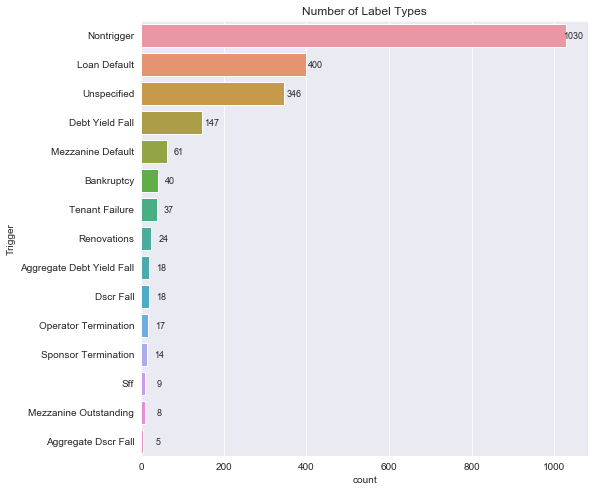

In [105]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Label Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [29]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    133
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    130
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    117
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    109
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     95
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     77
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     71
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     69
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     68
20170801_02DX5C_Prospectus_SD000000002363000910.pdf     

In [30]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [31]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [32]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [33]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [35]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [36]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sum
Document,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,63.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,117.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,62.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,68.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,69.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,64.0


In [37]:
# Export reshaped to CSV file
#doc_view.to_csv('../data/doc_view_06_04_20.csv')

In [38]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [39]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [40]:
df.shape

(1933, 17)

## Feature Engineering

In [41]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [42]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [43]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [44]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [45]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [46]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [47]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [49]:
for lemma in doc:
    print(lemma,  lemma.pos_, lemma.tag_, lemma.dep_, lemma.shape_,  lemma.is_stop)

The DET DT  Xxx False
Mortgage PROPN NNP  Xxxxx False
Loan PROPN NNP  Xxxx False
Documents PROPN NNPS  Xxxxx False
require VERB VBP  xxxx False
the DET DT  xxx True
lender NOUN NN  xxxx False
to PART TO  xx True
maintain VERB VB  xxxx False
the DET DT  xxx True
Cash PROPN NNP  Xxxx False
Management PROPN NNP  Xxxxx False
Account PROPN NNP  Xxxxx False
, PUNCT ,  , False
and CCONJ CC  xxx True
the DET DT  xxx True
Borrower PROPN NNP  Xxxxx False
to PART TO  xx True
remit VERB VB  xxxx False
, PUNCT ,  , False
or CCONJ CC  xx True
cause VERB VB  xxxx False
to PART TO  xx True
be VERB VB  xx True
remitted VERB VBN  xxxx False
funds NOUN NNS  xxxx False
into ADP IN  xxxx True
the DET DT  xxx True
operating NOUN NN  xxxx False
account NOUN NN  xxxx False
maintained VERB VBN  xxxx False
by ADP IN  xx True
the DET DT  xxx True
Hotel PROPN NNP  Xxxxx False
Operator PROPN NNP  Xxxxx False
for ADP IN  xxx True
disbursement NOUN NN  xxxx False
into ADP IN  xxxx True
the DET DT  xxx True
Cash PROP

Account PROPN NNP  Xxxxx False
” PUNCT ''  ” False
; PUNCT :  ; False
during ADP IN  xxxx True
the DET DT  xxx True
continuance NOUN NN  xxxx False
of ADP IN  xx True
a DET DT  x True
Hotel PROPN NNP  Xxxxx False
Operating PROPN NNP  Xxxxx False
Agreement PROPN NNP  Xxxxx False
Cash PROPN NNP  Xxxx False
Trap PROPN NNP  Xxxx False
Period PROPN NNP  Xxxxx False
, PUNCT ,  , False
an DET DT  xx True
account NOUN NN  xxxx False
for ADP IN  xxx True
the DET DT  xxx True
purpose NOUN NN  xxxx False
of ADP IN  xx True
reserving VERB VBG  xxxx False
all DET DT  xxx True
remaining VERB VBG  xxxx False
amounts NOUN NNS  xxxx False
after ADP IN  xxxx True
the DET DT  xxx True
payment NOUN NN  xxxx False
of ADP IN  xx True
items NOUN NNS  xxxx False
( PUNCT -LRB-  ( False
i PUNCT LS  x True
) PUNCT -RRB-  ) False
through ADP IN  xxxx True
( PUNCT -LRB-  ( False
ix X FW  xx False
) PUNCT -RRB-  ) False
under ADP IN  xxxx True
“ PUNCT ``  “ False
—Cash PROPN NNP  —Xxxx False
Management PROPN NNP  X

In [50]:
df[df['SentenceLemmas'].str.contains('marriott')]

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas
62,20160510_02B0XU_Prospectus_SD00000000231272338...,"On each Mortgage Loan Payment Date, other than...",1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2663,"On each Mortgage Loan Payment Date , other tha...","on each mortgage loan payment date , other tha..."
67,20160510_02B0XU_Prospectus_SD00000000231272338...,“Lockbox Period” means any time when the Mortg...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,236,“ Lockbox Period ” means any time when the Mor...,""" lockbox period "" mean any time when the mort..."
68,20160510_02B0XU_Prospectus_SD00000000231272338...,The Mortgage Loan Documents require the lender...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3608,The Mortgage Loan Documents require the lender...,the mortgage loan documents require the lender...
81,20160510_02B0XU_Prospectus_SD00000000231272338...,During any time when the Mortgage Loan is outs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,372,During any time when the Mortgage Loan is outs...,during any time when the mortgage loan be outs...
83,20160510_02B0XU_Prospectus_SD00000000231272338...,"On each Mortgage Loan Payment Date, other than...",1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2418,"On each Mortgage Loan Payment Date , other tha...","on each mortgage loan payment date , other tha..."
84,20160510_02B0XU_Prospectus_SD00000000231272338...,In the event no Marriott Management Period or ...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,266,In the event no Marriott Management Period or ...,in the event no marriott management period or ...
347,20190108_02IFF1_Prospectus_SD00000000257045846...,"Mortgage Lender and Borrower agree that, provi...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1725,"Mortgage Lender and Borrower agree that , prov...","mortgage lender and borrower agree that , prov..."
798,20160510_02B0XU_Prospectus_SD00000000231272338...,For so long as a Marriott Management Period or...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,320,For so long as a Marriott Management Period or...,for so long as a marriott management period or...
804,20160510_02B0XU_Prospectus_SD00000000231272338...,“Marriott Management Period” means any period ...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,285,“ Marriott Management Period ” means any perio...,""" marriott management period "" mean any period..."
809,20160510_02B0XU_Prospectus_SD00000000231272338...,"On each Mortgage Loan Payment Date, the Borrow...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1053,"On each Mortgage Loan Payment Date , the Borro...","on each mortgage loan payment date , the borro..."


In [51]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [52]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [53]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [54]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [55]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

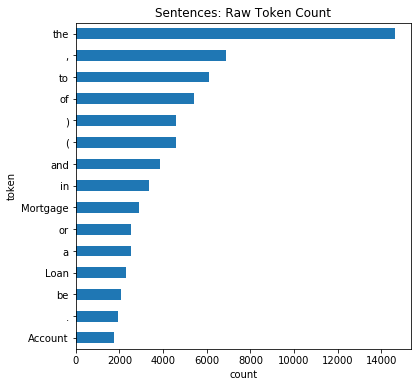

In [56]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

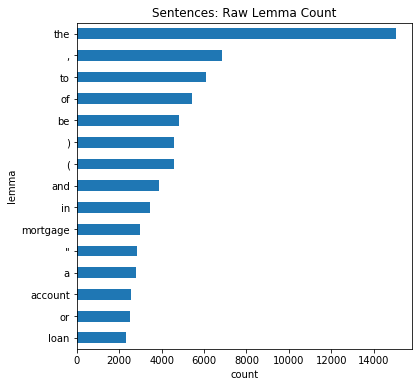

In [57]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [58]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [59]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

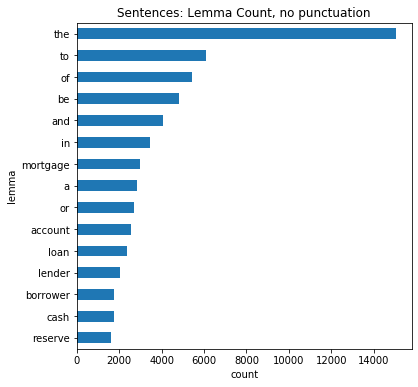

In [60]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [61]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [62]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [63]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [64]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']

In [65]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['without',
 'all',
 'only',
 'become',
 'almost',
 'front',
 'side',
 'whatever',
 'along',
 'otherwise',
 'again',
 'elsewhere',
 'any',
 'we',
 'four',
 'each',
 'used',
 'here',
 'becomes',
 'i',
 'over',
 'sometime',
 'call',
 'their',
 'through',
 'whole',
 'fifteen',
 'wherein',
 'am',
 'meanwhile',
 'still',
 'thus',
 'toward',
 'onto',
 'or',
 'part',
 'was',
 'already',
 'she',
 'mine',
 'there',
 'whereafter',
 'yet',
 'be',
 'due',
 'therefore',
 'it',
 'afterwards',
 'for',
 'yourself',
 'is',
 'did',
 'every',
 'own',
 'hence',
 'whenever',
 'which',
 'your',
 'twelve',
 'anyone',
 'nevertheless',
 'but',
 'who',
 'perhaps',
 'least',
 'three',
 'formerly',
 'so',
 'when',
 'whereas',
 'nor',
 'before',
 'except',
 'if',
 'thence',
 'anywhere',
 'both',
 'name',
 'her',
 'six',
 'via',
 'serious',
 'thereafter',
 'these',
 'among',
 'always',
 'done',
 'just',
 'upon',
 'since',
 'will',
 'unless',
 'this',
 'doing',
 'beforehand',
 'somewhere',
 'everywhere',
 'seeming',

## Train/Test Split

In [66]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [67]:
# Start by predicting Loan Default trigger

target = 'bankruptcy'


X = df['SentenceLemmas_nopunc']
y = df[target]
indices = df.index

y = y.astype('int')

In [68]:
y.dtypes

dtype('int64')

In [69]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (1933,)
y shape is (1933,)


In [70]:
y.value_counts()

0    1893
1      40
Name: bankruptcy, dtype: int64

In [71]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(indices_train.shape, indices_test.shape)

(1353,) (1353,)
(580,) (580,)
(1353,) (580,)


In [72]:
X.head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [73]:
X_train.shape[0]

1353

In [74]:
y_train.shape[0]

1353

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [75]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 271.600


In [76]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.964
Test score is 0.667
Cross Validation score is 0.990
Seconds elapsed for score calculation: 1.089


In [77]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.850
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 400, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']}


### 5: CountVectorizor + Random Forest

In [78]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

"\n# Define CVEC + Logistic Regression Pipeline\npipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])\nrf_params = {\n    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],\n    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  \n    'cvec__max_features': [100, 200, 400, 800],\n    'cvec__min_df': [2],\n    'cvec__max_df': [.99],\n    'rf__max_depth': [4,5, 6],\n    'rf__min_samples_split': [2,3],\n    'rf__min_samples_leaf': [10, 12]\n    }\n\ngs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')\n\n# Start the timer.\nt0 = time.time()\n\nresults_rf = gs_rf.fit(X_train, y_train)\n\nprint(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.\n\n"

In [79]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

"\nt0 = time.time()\nprint(f'Training score is {results_rf.score(X_train, y_train):.3f}')\nprint(f'Test score is {results_rf.score(X_test, y_test):.3f}')\nprint(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')\nprint(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.\n"

In [80]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

"\nprint(f'Best Score: {results_rf.best_score_}')\nprint(f'Best Parameters: {results_rf.best_params_}')\n"

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [81]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.979
CountVectorizer + LogisticRegression Accuracy: 0.964


In [82]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.979
CountVectorizer + LogisticRegression Accuracy: 0.667


## Model Evaluation - Logistic Regression

In [83]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [84]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.0656425188153753,
 0.08849643769919902,
 0.09484500437591634,
 -0.005102099567474736,
 0.22157306409972072,
 -0.024914106579444616,
 -0.6709941831017995,
 0.031959784246738454,
 -0.009661707639764379,
 -0.01728113255470373]

In [85]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [86]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [87]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
49,bankruptcy,1.029869
13,action,0.874350
250,of borrower,0.848176
160,have occur,0.399331
191,iv,0.374384
289,portion,0.349745
291,principal,0.347951
297,property manager,0.312196
223,manager,0.292593
76,clause,0.286610


In [88]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
6,account,-0.670994
170,in,-0.638153
225,mean,-0.622589
25,an,-0.541302
388,will,-0.485154
150,from,-0.439690
323,reserve,-0.424503
211,lockbox,-0.397587
294,pron,-0.385154
272,other,-0.385122


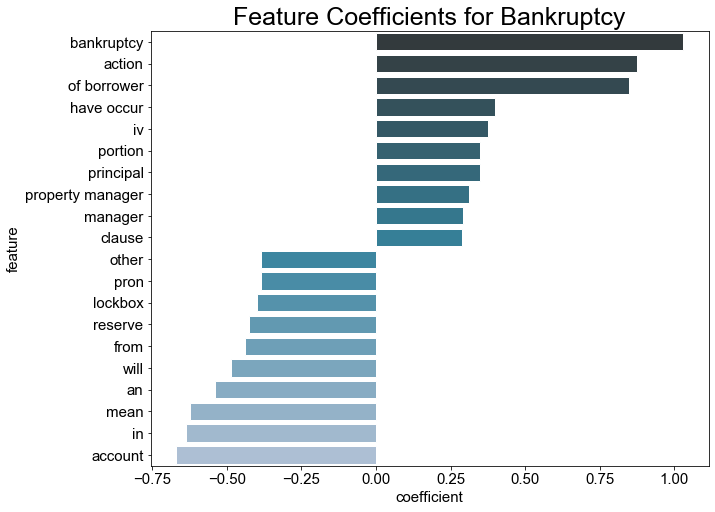

In [89]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [90]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [91]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[568   0]
 [  6   6]]


In [93]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [94]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,568,0
Actual Positive,6,6


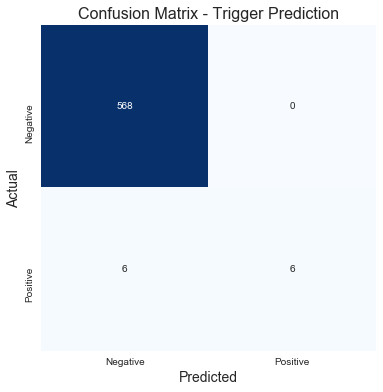

In [95]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [96]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

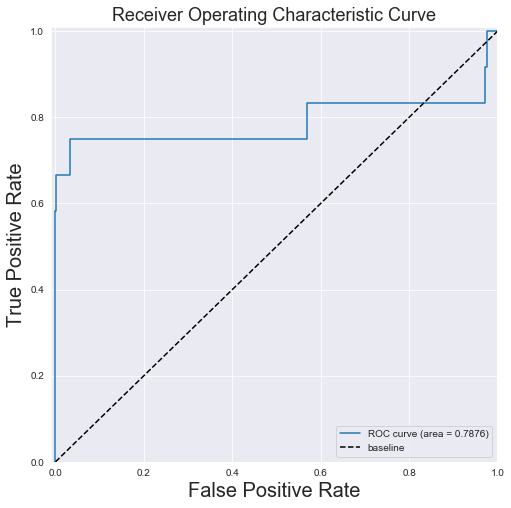

In [97]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [98]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [99]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

In [100]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
753,0,0,eligible institution mean with regard to this description of the mortgage loan an institution i whose short term unsecured debt obligation or commercial paper of which be rat at least a 1 by s p p 1 by moody s and if rat by fitch f 1 by fitch in the case of account in which fund be hold for 30 day or less or in the case of account in which fund be hold for more than 30 day the long term unsecured debt obligation of which be rat at least aa by s p and fitch if rat by fitch and a2 by moody s and whose deposit be insure by the fdic or ii with respect to which the rating condition be satisfied without limit the foregoing each of u s bank national association harris bank and trust bank of america n a pnc bank jpmorgan chase bank n a key bank n a m t bank corporation wells fargo bank national association and PRON respective successor and assign by merger will be deem to be eligible institutions so long as PRON maintain a long term unsecured debt rating of not less than a by s p a2 and p1 from moody s and an equivalent rating by the other rating agencies to the extent that such rating agency rate such institution
1112,0,0,see description of the mortgage loan loss proceeds account basic carrying costs escrow fund ff e reserve account excess cash flow reserve account and cash management account in the offering circular
427,0,0,additionally if at any time during a trigger period mortgage lender reasonably determine that amount on deposit in or schedule to be deposit in the ground rent account will be insufficient to pay all ground rent in full on the next due date the borrower will make a true up payment with respect to such insufficiency into the ground rent account
1640,0,0,the loan document require a furniture fixture and equipment ff e reserve as outline herein
1493,0,0,amount so deposit be refer to as the immediate repair funds


In [101]:
misclassified = results[results['prediction'] != results['actual']]


In [102]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [106]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]

In [107]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
1847,0,1,a full cash flow sweep period be trigger upon i the debt yield calculate base on the total debt fall for two consecutive quarter below 6 00 ii an event of default under the mortgage loan or mezzanine loan or iii the occurrence of certain bankruptcy or insolvency event with respect to the borrowers a cash sweep period,20190305_02IZYJ_Prospectus_SD000000002595913797.pdf,"A full cash flow sweep period is triggered upon (i) the Debt Yield (calculated based on the Total Debt) falling for two consecutive quarters below 6.00%, (ii) an event of default under the Mortgage Loan or Mezzanine Loan or (iii) the occurrence of certain bankruptcy or insolvency events with respect to the Borrowers (a “Cash Sweep Period”).",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1842,0,1,so long as no mortgage loan event of default have occur and be continue or certain bankruptcy action with respect to a borrower have not occur the borrowers will have access to the excess cash flow reserve fund and such amount will be require to be disburse by the mortgage lender to the borrowers within three business days of the borrowers write request to pay for cost and expense in connection with the ownership management and or operation of the properties include without limitation for i payment of shortfall in the payment of debt service and or mezzanine debt service ii payment of shortfall in the require deposit into the reserve funds in each case to the extent require in the mortgage loan agreement or the cash management agreement iii at the borrowers option principal prepayment of the mortgage loan and any mezzanine loan iv at the borrowers option prepayment which be require to satisfy any debt yield test under the mortgage loan agreement provide such prepayment be make pro rata between the mortgage loan and each mezzanine loan v payment of operating expense include capital expenditure vi payment of management fee due and payable under the management agreements vii payment of emergency repair and or life safety item include any such repair or item which be capital in nature with respect to which the mortgage lender be require to endeavor to fund or because PRON servicer to fund such request within one business day of request by the borrowers provide further that any failure to fund such request within one business day will in no event create any liability for the mortgage lender under the mortgage loan agreement viii payment of tenant improvement cost tenant allowance tenant relocation cost tenant reimbursement tenant inducement payment and leasing commission obligation or other expenditure require under lease include tenant improvement cost tenant allowance tenant relocation cost tenant reimbursement and leasing commission obligation or other expenditure require pursuant to a lease which be incur or otherwise payable in connection with the entering into renewal and or extension of a lease enter into in accordance with the term of the mortgage loan agreement or exist as of the origination date ix cost associate with the interest rate cap agreement or with respect to the mortgage loan or any mezzanine loan include replacement interest rate cap agreements substitute interest rate cap agreements and convert interest rate cap agreements x vacant space preparation cost and marketing cost with respect to potential leasing at the properties xi payment of any shortfall of net proceeds with respect the cost of restoration of a property after a casualty or condemnation incur by or on behalf of the borrowers in connection therewith xii payment of any fee and cost which be due and payable to the mortgage lender or PRON servicer pursuant to the mortgage loan documents or any mezzanin

In [108]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [109]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 6 sentences.


In [110]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

0    6
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [111]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,


In [112]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [113]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

0 sentences were predicted to be the trigger category, but in fact were not this category.


In [114]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
sum,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Misclassifications: wrongly predicted NOT to be the trigger category

In [116]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
1847,0,1,a full cash flow sweep period be trigger upon i the debt yield calculate base on the total debt fall for two consecutive quarter below 6 00 ii an event of default under the mortgage loan or mezzanine loan or iii the occurrence of certain bankruptcy or insolvency event with respect to the borrowers a cash sweep period,20190305_02IZYJ_Prospectus_SD000000002595913797.pdf,"A full cash flow sweep period is triggered upon (i) the Debt Yield (calculated based on the Total Debt) falling for two consecutive quarters below 6.00%, (ii) an event of default under the Mortgage Loan or Mezzanine Loan or (iii) the occurrence of certain bankruptcy or insolvency events with respect to the Borrowers (a “Cash Sweep Period”).",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1842,0,1,so long as no mortgage loan event of default have occur and be continue or certain bankruptcy action with respect to a borrower have not occur the borrowers will have access to the excess cash flow reserve fund and such amount will be require to be disburse by the mortgage lender to the borrowers within three business days of the borrowers write request to pay for cost and expense in connection with the ownership management and or operation of the properties include without limitation for i payment of shortfall in the payment of debt service and or mezzanine debt service ii payment of shortfall in the require deposit into the reserve funds in each case to the extent require in the mortgage loan agreement or the cash management agreement iii at the borrowers option principal prepayment of the mortgage loan and any mezzanine loan iv at the borrowers option prepayment which be require to satisfy any debt yield test under the mortgage loan agreement provide such prepayment be make pro rata between the mortgage loan and each mezzanine loan v payment of operating expense include capital expenditure vi payment of management fee due and payable under the management agreements vii payment of emergency repair and or life safety item include any such repair or item which be capital in nature with respect to which the mortgage lender be require to endeavor to fund or because PRON servicer to fund such request within one business day of request by the borrowers provide further that any failure to fund such request within one business day will in no event create any liability for the mortgage lender under the mortgage loan agreement viii payment of tenant improvement cost tenant allowance tenant relocation cost tenant reimbursement tenant inducement payment and leasing commission obligation or other expenditure require under lease include tenant improvement cost tenant allowance tenant relocation cost tenant reimbursement and leasing commission obligation or other expenditure require pursuant to a lease which be incur or otherwise payable in connection with the entering into renewal and or extension of a lease enter into in accordance with the term of the mortgage loan agreement or exist as of the origination date ix cost associate with the interest rate cap agreement or with respect to the mortgage loan or any mezzanine loan include replacement interest rate cap agreements substitute interest rate cap agreements and convert interest rate cap agreements x vacant space preparation cost and marketing cost with respect to potential leasing at the properties xi payment of any shortfall of net proceeds with respect the cost of restoration of a property after a casualty or condemnation incur by or on behalf of the borrowers in connection therewith xii payment of any fee and cost which be due and payable to the mortgage lender or PRON servicer pursuant to the mortgage loan documents or any mezzanin

In [117]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]


In [118]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

6 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [119]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger
index,,,,,,,,,,,,,,,,
1847,0.0,1.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1842,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
275,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
700,0.0,1.0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
1819,0.0,1.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
365,0.0,1.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
sum,0.0,6.0,6,1,0,0,3,0,1,0,0,0,6,0,1,0


### Export Misclassification summaries

In [ ]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_false_06_04_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_true_06_04_20.csv')